In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [13]:
class attack_defence_agents(nn.Module):
    def __init__(self, input_size = 7*2, seq_len = 10 ,hidden_size = 128, output_size = 7):
        super().__init__()

        self.a_lstm = nn.LSTM(input_size, hidden_size, batch_first = True, num_layers=2)
        self.a_fc = nn.Linear(hidden_size, hidden_size)
        self.a_fc2 = nn.Linear(hidden_size, output_size)        
        
        self.b_lstm = nn.LSTM(input_size, hidden_size, batch_first = True, num_layers=2)
        self.b_fc = nn.Linear(hidden_size, hidden_size)
        self.b_fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x, agent):
        if agent == 'a':
            x, (hn, cn) = self.a_lstm(x)
            x = hn[-1]
            x = F.relu(self.a_fc(x))
            x = self.a_fc2(x)
        elif agent == 'b':
            x, (hn,cn) = self.b_lstm(x)
            x = hn[-1]
            x = F.relu(self.b_fc(x))
            x = self.b_fc2(x)
        return x
model = attack_defence_agents()

In [14]:
attack_train_x = np.load('attack_path_inputs_X.npy')
attack_train_y = np.load('attack_path_inputs_Y.npy')

attack_input_norm = np.max(np.abs(attack_train_x))
attack_output_norm = np.max(np.abs(attack_train_y))

attack_train_x = attack_train_x / np.max(np.abs(attack_train_x))
attack_train_y = attack_train_y / np.max(np.abs(attack_train_y))

attack_train_x = attack_train_x.reshape(attack_train_x.shape[0], attack_train_x.shape[1], attack_train_x.shape[2]*attack_train_x.shape[3])

defence_train_x = np.load('defence_path_inputs_X.npy')
defence_train_y = np.load('defence_path_inputs_Y.npy')

defence_input_norm = np.max(np.abs(defence_train_x))
defence_output_norm = np.max(np.abs(defence_train_y))

defence_train_x = defence_train_x / np.max(np.abs(defence_train_x))
defence_train_y = defence_train_y / np.max(np.abs(defence_train_y))

defence_train_x = defence_train_x.reshape(defence_train_x.shape[0], defence_train_x.shape[1], defence_train_x.shape[2]*defence_train_x.shape[3])


attack_train_x = torch.tensor(attack_train_x, dtype=torch.float32)
attack_train_y = torch.tensor(attack_train_y, dtype=torch.float32)

defence_train_x = torch.tensor(defence_train_x, dtype=torch.float32)
defence_train_y = torch.tensor(defence_train_y, dtype=torch.float32)

attack_set = torch.utils.data.TensorDataset(attack_train_x, attack_train_y)
defence_set = torch.utils.data.TensorDataset(defence_train_x, defence_train_y)

print(attack_train_x.shape, attack_train_y.shape)
print(defence_train_x.shape, defence_train_y.shape)
norms = [attack_input_norm, attack_output_norm, defence_input_norm, defence_output_norm]
np.save('norms.npy', norms)


torch.Size([25330, 10, 14]) torch.Size([25330, 7])
torch.Size([25058, 10, 14]) torch.Size([25058, 7])


epoch: 0, attack_loss: 3.0579909067600965, defence_loss: 4.481304103508592
epoch: 1, attack_loss: 1.0959552596323192, defence_loss: 2.0446819867938757
epoch: 2, attack_loss: 0.36882218555547297, defence_loss: 1.0932289231568575
epoch: 3, attack_loss: 0.12016668368596584, defence_loss: 0.7564125438220799
epoch: 4, attack_loss: 0.033197015698533505, defence_loss: 0.621360631659627
epoch: 5, attack_loss: 0.017283168250287417, defence_loss: 0.5715963528491557
epoch: 6, attack_loss: 0.015390026237582788, defence_loss: 0.505039248149842
epoch: 7, attack_loss: 0.012016426233458333, defence_loss: 0.41800086898729205
epoch: 8, attack_loss: 0.011285359636531211, defence_loss: 0.32870887336321175
epoch: 9, attack_loss: 0.010804476049088407, defence_loss: 0.2426150906831026
epoch: 10, attack_loss: 0.010129915812285617, defence_loss: 0.18574199231807142
epoch: 11, attack_loss: 0.010216017763013951, defence_loss: 0.16406429966446012
epoch: 12, attack_loss: 0.008764604426687583, defence_loss: 0.15490

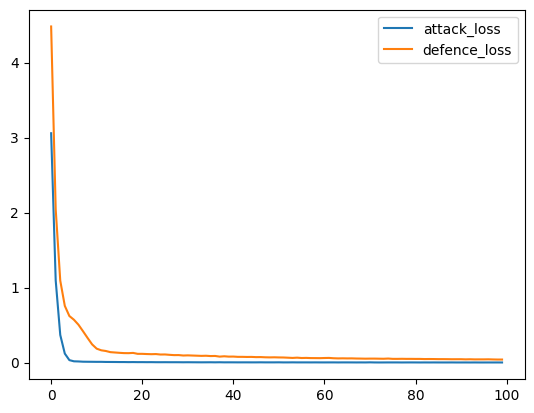

In [15]:
epoch_num = 100
batch_size = 256

attack_loader = torch.utils.data.DataLoader(attack_set, batch_size=batch_size, shuffle=True)
defence_loader = torch.utils.data.DataLoader(defence_set, batch_size=batch_size, shuffle=True)

attack_optimizer = optim.Adam(model.parameters(), lr=0.001)
defence_optimizer = optim.Adam(model.parameters(), lr=0.001)

attack_loss_fn = nn.MSELoss()
defence_loss_fn = nn.MSELoss()

attack_losses = []
defence_losses = []

for epoch in range(epoch_num):
    attack_loss = 0
    defence_loss = 0
    model.train()
    for x, y in attack_loader:
        attack_optimizer.zero_grad()
        y_pred = model(x, 'a')
        loss = attack_loss_fn(y_pred, y)
        loss.backward()
        attack_optimizer.step()
        attack_loss += loss.item()
    attack_losses.append(attack_loss)
    
    for x, y in defence_loader:
        defence_optimizer.zero_grad()
        y_pred = model(x, 'b')
        loss = defence_loss_fn(y_pred, y)
        loss.backward()
        defence_optimizer.step()
        defence_loss += loss.item()
    defence_losses.append(defence_loss)
    print(f'epoch: {epoch}, attack_loss: {attack_loss}, defence_loss: {defence_loss}')
#save the model
torch.save(model.state_dict(), 'attack_defence_model.pth')
plt.plot(attack_losses, label='attack_loss')
plt.plot(defence_losses, label='defence_loss')
plt.legend()
plt.show()

In [16]:
import robotic as ry
import time
import numpy as np
import os
import time
import matplotlib.pyplot as plt

C = ry.Config()
C.addFile("rai-robotModels/scenarios/pandasFight.g")
C.view()


0

In [17]:
armed=np.load('armed.npy')

In [18]:
#Define simulation functions
C = ry.Config()
C.addFile("rai-robotModels/scenarios/pandasFight.g")

C.setJointState(np.array([ 0.  , -1.  ,  0.  , -2.  ,  0.  ,  2.  ,  0.  ,  0.  ,
       -1.  ,  0.  , -2.  ,  0.  ,  2.  ,  0.]))

q0 = C.getJointState()
S = ry.Simulation(C, ry.SimulationEngine.physx, verbose=0)
def simulationCloseGrippers(S, tau=0.01):
    S.closeGripper('l_gripper', width=0.0001, speed=0.5)
    while (not S.getGripperIsGrasping('l_gripper')) and (S.getGripperWidth('l_gripper') > 0.001):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        C.view()
    
    S.closeGripper('r_gripper', width=0.0001, speed=0.5)
    while (not S.getGripperIsGrasping('r_gripper')) and (S.getGripperWidth('r_gripper') > 0.001):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        C.view()


def simulationOpenGrippers(S, tau=0.01):
    S.openGripper('l_gripper', width=0.05, speed=0.5)
    while S.getGripperWidth('l_gripper') < 0.05 - 0.01:
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        C.view()
    S.openGripper('r_gripper', width=0.05, speed=0.5)
    while S.getGripperWidth('r_gripper') < 0.05 - 0.01:
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        C.view()

def simulationGoTo(S, q, tau=0.01, checkCol=False):
    checkColTime = 0.1
    timer = 0
    while np.linalg.norm(S.get_q() - q) > 0.01:
        time.sleep(tau)
        S.step(q, tau, ry.ControlMode.position)
        timer += tau
        C.view()
        if timer > 4:
            print("Target cannot be reached within 4 seconds.")
            break
        if checkCol:
            if timer > checkColTime:
                if findCollision(C, 'sword_1'):
                    return
                else:
                    checkColTime += 0.1

def simulationGoHome(S, tau=0.01):
    checkColTime = 0.1
    timer = 0
    while np.linalg.norm(S.get_q() - q0) > 0.01:
        time.sleep(tau)
        S.step(q0, tau, ry.ControlMode.position)
        C.view()
        timer += tau
        # if timer > checkColTime:
        #     if findCollision(C, 'sword_1'):
        #         break
        #     else:
        #         checkColTime += 0.1
            
def simulationFollowPath(S, path, tau=0.01):
    checkColTime = 0.1
    timer = 0
    for i in range(len(path)):
        while np.linalg.norm(S.get_q() - path[i]) > 0.3:
            time.sleep(tau)
            print(i)
            print(np.linalg.norm(S.get_q() - path[i]))
            S.step(path[i], tau, ry.ControlMode.position)
            #C.view()
            timer += tau
            if timer > checkColTime:
                print('check_col')
                if findCollision(C, 'sword_1'):
                    return
                else:
                    checkColTime += 0.1

    simulationGoTo(S, path[-1], checkCol=True)

def simulationWait(S, t, tau=0.01):
    for k in range(int(t / tau)):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        #C.view()

def simulationTorqueCtrl(S, t, torque, tau=0.01):
    for k in range(int(t / tau)):
        time.sleep(tau)
        S.step(torque, tau, ry.ControlMode.acceleration)
        #C.view()

def simulationVelocityCtrl(S,t,vel,tau=0.01):
    for k in range(int(t/tau)):
        time.sleep(tau)
        S.step(vel,tau,ry.ControlMode.velocity)
        #C.view()

def followInterpolatedPath(S,path,tau=0.01):
    checkColTime = 0.1
    timer = 0
    for i in range(len(path)):
        time.sleep(tau)
        print(i)
        print(np.linalg.norm(S.get_q()- path[i]))
        S.step(path[i],tau,ry.ControlMode.position)
        #C.view()
        timer += tau
        if timer > checkColTime:
            if findCollision(C,'sword_1'):
                return
            else:
                checkColTime += 0.1
    simulationGoTo(S,path[-1],checkCol=True)

def findCollision(C,object1):
    collisions = [col for col in C.getCollisions(0) if object1 in col and not col[1].startswith('l_') and not col[0].startswith('l_')]
    if len(collisions) > 0:
        return True
    else:
        return False
    
# Use this code. It is awesome. It will follow the path and stop if there is a collision.    
def followSplinePath(S,C,path,t,tau=0.01):
    """
        Guides a simulation object along a specified spline path.
        Parameters:
        S (Simulation): The simulation object that will follow the path.
        path (array): A list of waypoints defining the spline path.
        t (float): The total time duration for following the path.
        tau (float, optional): The time step for each simulation step. Default is 0.01.
        The function performs the following steps:
        1. Resets the spline reference of the simulation object.
        2. Sets the spline reference with the given path and a time vector.
        3. Iteratively steps through the simulation, updating the view and checking for collisions.
        4. If a collision with 'sword_1' is detected, the function exits early.
        5. The loop runs for a duration slightly longer than `t` to ensure completion.
        Note:
        - The `+20` in the loop range is a heuristic to prevent early termination when `t` is low.
        - The function checks for collisions every 0.1 seconds.

    """
    checkColTime = 0.1
    timer = 0
    S.resetSplineRef() # Reset previous spline reference
    S.setSplineRef(path,np.linspace(0.01,t,len(path))) # Set new spline reference
    joint_data = np.empty((int(t/tau)+20, 2,S.get_q().shape[0])) # Initialize array to store joint data
    for k in range(int(t/tau)+20): # This +20 is heuristic. It was stopping after a short time when t was low.
        time.sleep(tau)
        S.step([],tau,ry.ControlMode.spline)
        inst_pos = S.get_q().copy()
        inst_vel = S.get_qDot().copy()
        C.view(message=f"Time: {timer:.2f} s")
        timer += tau
        joint_data[k,0,:] = inst_pos
        joint_data[k,1,:] = inst_vel
        if timer > checkColTime: # Check for collisions every 0.1 seconds
            if findCollision(C,'sword_1'): # Check if sword is colliding with something (left robot is excluded (no self collision))
                return joint_data[:k,:,:] # Return the joint data until collision
            else:
                checkColTime += 0.1 # Increment the collision check time

    return joint_data[np.newaxis,:,:,:]
    #simulationGoTo(S,path[-1],checkCol=True) 


In [19]:
import time
def initializeSimulation():
    simulationGoTo(S,armed)
    simulationCloseGrippers(S)
    simulationGoHome(S)

In [24]:
print(attack_input_norm)
print(attack_output_norm)
print(defence_input_norm)
print(defence_output_norm)

11.093210220336914
2.9823179244995117
46.03759812352496
2.926783800125122


In [25]:
C = ry.Config()
C.addFile("rai-robotModels/scenarios/pandasFight.g")

C.setJointState(np.array([ 0.  , -1.  ,  0.  , -2.  ,  0.  ,  2.  ,  0.  ,  0.  ,
       -1.  ,  0.  , -2.  ,  0.  ,  2.  ,  0.]))

q0 = C.getJointState()
random_joint_states = q0+np.random.uniform(-1,1,14)*0.15*np.pi

S = ry.Simulation(C, ry.SimulationEngine.physx, verbose=0)
initializeSimulation()
simulationGoTo(S,random_joint_states)
C.view()
time.sleep(1)
a_data = np.empty((10,14))
d_data = np.empty((10,14))
model.eval()
for i in range(200):

    if i > 10:
        attack = model(torch.tensor(a_data[np.newaxis,:,:], dtype=torch.float32), 'a').detach().numpy()
        defence = model(torch.tensor(d_data[np.newaxis,:,:], dtype=torch.float32), 'b').detach().numpy()
        target_pos = np.concatenate([attack[0]* attack_output_norm,defence[0] * defence_output_norm])
    else:
        target_pos = C.getJointState()

    S.step(target_pos, 0.01, ry.ControlMode.position)
    pos = S.get_q()
    vel = S.get_qDot()
    a_data[i%10,0:7] = pos[0:7]
    a_data[i%10,7:] = vel[0:7]

    d_data[i%10,0:7] = pos[7:]
    d_data[i%10,7:] = vel[7:]
    C.view()
    

del C
del S

-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]
